In [64]:
import train_fnn
from fnn_model import FNNDecoder
from dataset import generate_errors, pauli_to_XZ, syndrome, Hx, Hz
print("Hx= \n",Hx)
print("Hz= \n",Hz)

Hx= 
 [[0 1 1 0 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 0 1 1 0]]
Hz= 
 [[1 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 1]]


In [69]:
import numpy as np

# Logical X operators
LX1 = [0,1,0,1,1,0,1,1,0]
LX2 = [0,0,0,0,0,0,1,1,1]
LX3 = [0,1,0,1,1,0,0,0,1]

# Logical Z operators
LZ1 = [0,0,1,1,0,0,1,1,0]
LZ2 = [0,0,0,0,0,1,1,0,1]
LZ3 = [0,0,1,1,0,1,0,1,1]

LX1 = np.array(LX1)
LX2 = np.array(LX2)
LX3 = np.array(LX3)

LZ1 = np.array(LZ1)
LZ2 = np.array(LZ2)
LZ3 = np.array(LZ3)

In [68]:
model = train_fnn.main()

Epoch 1: Loss = 71.0338
Epoch 2: Loss = 44.8191
Epoch 3: Loss = 39.5314
Epoch 4: Loss = 37.2854
Epoch 5: Loss = 36.0173
Epoch 6: Loss = 35.5629
Epoch 7: Loss = 33.7985
Epoch 8: Loss = 32.7109
Epoch 9: Loss = 33.6612
Epoch 10: Loss = 32.1082
Epoch 11: Loss = 31.8015
Epoch 12: Loss = 30.8166
Epoch 13: Loss = 31.0714
Epoch 14: Loss = 30.7409
Epoch 15: Loss = 30.7599
Epoch 16: Loss = 30.6949
Epoch 17: Loss = 30.5686
Epoch 18: Loss = 29.7175
Epoch 19: Loss = 28.9614
Epoch 20: Loss = 29.2714
Epoch 21: Loss = 28.7894
Epoch 22: Loss = 28.4082
Epoch 23: Loss = 28.3554
Epoch 24: Loss = 28.6675
Epoch 25: Loss = 28.1070
Epoch 26: Loss = 28.0596
Epoch 27: Loss = 27.9577
Epoch 28: Loss = 28.2244
Epoch 29: Loss = 27.8978
Epoch 30: Loss = 27.7798
Epoch 31: Loss = 27.4241
Epoch 32: Loss = 27.0324
Epoch 33: Loss = 27.0988
Epoch 34: Loss = 26.7864
Epoch 35: Loss = 26.8853
Epoch 36: Loss = 26.8547
Epoch 37: Loss = 27.0654
Epoch 38: Loss = 27.3097
Epoch 39: Loss = 26.6043
Epoch 40: Loss = 26.9168
Epoch 41:

In [94]:
import numpy as np
import torch
def evaluate_decoder(model, p, num_samples=3000):

  n_qubits = Hx.shape[1]
    
  # Generate Pauli Errors
  errors = generate_errors(num_samples, n_qubits, p, p, p)

  # Convert IXYZ to eX,eZ channels
  eX, eZ = pauli_to_XZ(errors)

  # Compute syndromes
  sX = syndrome(Hx, eZ).T
  sZ = syndrome(Hz, eX).T
  s = np.concatenate([sX, sZ], axis=1)

  X = torch.tensor(s, dtype=torch.float32) # syndrome input
  yX = torch.tensor(eX, dtype=torch.int64) # X errors
  yZ = torch.tensor(eZ, dtype=torch.int64) # Z errors

  with torch.no_grad():
      pX_logits, pZ_logits = model(X)
      pX = (torch.sigmoid(pX_logits) > 0.5)
      pZ = (torch.sigmoid(pZ_logits) > 0.5)

  resX = (pX ^ yX).int()
  resZ = (pZ ^ yZ).int()
    
  LX = torch.tensor([LX1, LX2, LX3], dtype=torch.int64)
  LZ = torch.tensor([LZ1, LZ2, LZ3], dtype=torch.int64)

  resX64 = resX.to(torch.int64)
  resZ64 = resZ.to(torch.int64)

  logX_flips = (resX64 @ LX.T) % 2
  logZ_flips = (resZ64 @ LZ.T) % 2

  fail = ((logX_flips != 0).any(dim=1) | (logZ_flips != 0).any(dim=1))

  return fail.float().mean().item()

ps = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16]
results = []
for p in ps:
    rate = evaluate_decoder(model, p)
    results.append(rate)



Text(0, 0.5, 'Failure rate')

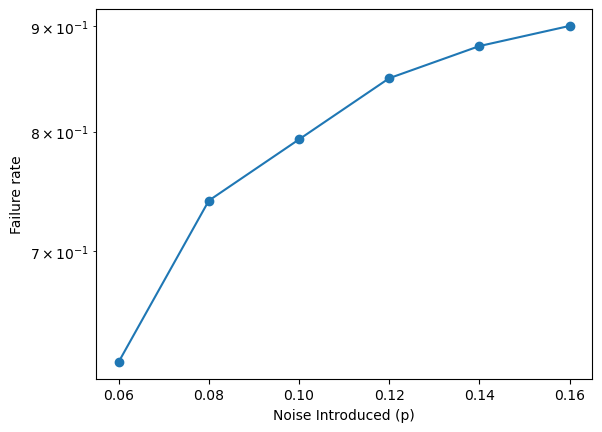

In [104]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.semilogy(ps, results, marker='o')
plt.xlabel("Noise Introduced (p)")
plt.ylabel("Failure rate")